# Texture Synthesis by Non-parametric Sampling

## Part 1: Setup and Helper Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Tuple, Optional

In [3]:
def load_texture(path: str, size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """Load a texture image and optionally resize it.
    
    Args:
        path: Path to the image file
        size: Optional tuple of (width, height) to resize the image to
        
    Returns:
        Loaded image as a numpy array with values in [0,1]
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if size:
        img = cv2.resize(img, size)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Original Texture')
    plt.show()
    return np.array(img) / 255.0

In [4]:
def visualize_progress(synthesized, mask, step=0):
    """Visualize the original texture and synthesis progress.
    
    Args:
        synthesized: Current state of synthesized texture
        mask: Binary mask showing filled pixels (1 = filled)
        step: Which step is now.
    """
    plt.figure(figsize=(5, 2))
    plt.subplot(121)
    plt.imshow(synthesized, cmap='gray')
    plt.title('Synthesized Texture')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(mask, cmap='gray')
    plt.title("Filled Pixel")
    plt.axis('off')
    plt.suptitle(f"Step {step}", y=0) 
    plt.show()

In [5]:
def get_unfilled_neighbors_count(mask: np.ndarray, window_size: int) -> np.ndarray:
    """Count number of filled neighbors for each unfilled pixel.
    
    Args:
        mask: Binary mask of filled pixels
        window_size: Size of neighborhood window
    
    Returns:
        Array with counts of filled neighbors for each unfilled pixel
    """
    kernel = np.ones((window_size, window_size))
    neighbors_count = cv2.filter2D(mask.astype(float), -1, kernel)
    neighbors_count[mask > 0] = -1  # Mark filled pixels with -1
    return neighbors_count

## Part 2: Implement Gaussian Window Creation

The algorithm uses a Gaussian-weighted window when comparing neighborhoods.

In [6]:
def create_gaussian_window(window_size: int, sigma: float = 1.0) -> np.ndarray:
    """Create a Gaussian window for neighborhood weighting.
    
    Args:
        window_size: Size of the window (should be odd)
        sigma: Standard deviation of the Gaussian
        
    Returns:[]
        2D Gaussian window
    """
    x = np.linspace(-1, 1, window_size)
    y = np.linspace(-1, 1, window_size)

    xy, yx = np.meshgrid(x, y)
    
    window = np.exp((-xy**2 - yx**2)/(2 * sigma**2))
    
    return window

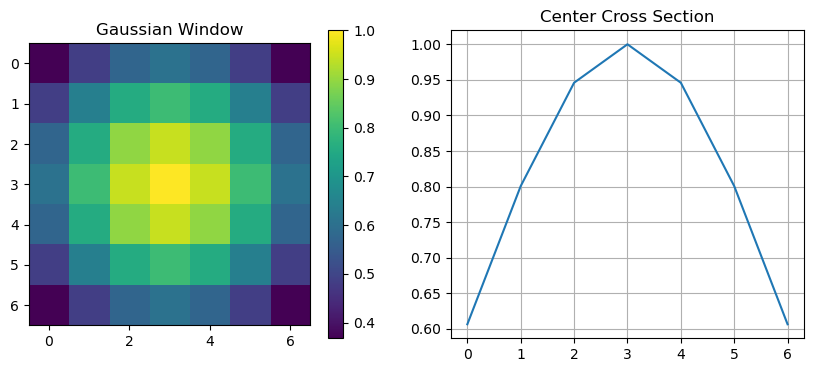

Window shape: (7, 7)
Max value (should be 1.0): 1.0
Center value (should be 1.0): 1.0
Corner value (should be small): 0.36787944117144233
Window is symmetric: True


In [7]:
def test_gaussian_window():
    # Create a 7x7 window
    window = create_gaussian_window(7, sigma=1.0)
    
    # Visualize the window
    plt.figure(figsize=(10, 4))
    
    plt.subplot(121)
    plt.imshow(window, cmap='viridis')
    plt.colorbar()
    plt.title('Gaussian Window')
    
    plt.subplot(122)
    plt.plot(window[window.shape[0]//2, :])
    plt.title('Center Cross Section')
    plt.grid(True)
    plt.show()
    
    # Basic checks
    print("Window shape:", window.shape)
    print("Max value (should be 1.0):", window.max())
    print("Center value (should be 1.0):", window[window.shape[0]//2, window.shape[0]//2])
    print("Corner value (should be small):", window[0,0])
    
    # Check symmetry
    print("Window is symmetric:", np.allclose(window, window.T))

test_gaussian_window()

## Part 3: Implement Neighborhood Matching (20pt)

This section implements the heart of the Efros-Leung algorithm: finding similar neighborhoods in the source texture. This is the most critical component that determines the quality of the synthesized texture. When synthesizing a pixel, we need to find all neighborhoods in the source texture that are "similar enough" to our target neighborhood, and then randomly choose one of them.

In [ ]:
def find_matching_neighborhoods(target_neighborhood: np.ndarray,
                              source_texture: np.ndarray,
                              gaussian_window: np.ndarray,
                              valid_mask: np.ndarray,
                              threshold: float = 0.01) -> list:
    good_matches = []

    weight = np.sum(valid_mask * gaussian_window)
 
    # width and height including valid padding
    ssd_width = source_texture.shape[0] - target_neighborhood.shape[0] + 1
    ssd_height = source_texture.shape[1] - target_neighborhood.shape[1] + 1
    ssd_matrix = np.zeros((ssd_width, ssd_height))
    
    # We now find the difference between the target neighborhood and every valid neighborhood in the source
    for x in range(ssd_matrix.shape[0]):
        for y in range(ssd_matrix.shape[1]):
            source_neighborhood = source_texture[x:target_neighborhood.shape[0] + x, y:target_neighborhood.shape[1] + y]
            dist = (source_neighborhood - target_neighborhood)**2
            # normalize by sum of valid weights
            ssd_matrix[x][y] = np.sum(dist * valid_mask * gaussian_window)/weight
    
    # Getting the indices for coordinates under threshold
    min_ssd = np.min(ssd_matrix)
    ssd_list = np.argwhere(ssd_matrix <= min_ssd * (1 + threshold))
    
    # adjusting coordinates back to source texture
    ssd_list[:,0] += target_neighborhood.shape[0] // 2
    ssd_list[:,1] += target_neighborhood.shape[1] // 2
    good_matches = ssd_list.tolist()
    
    return good_matches

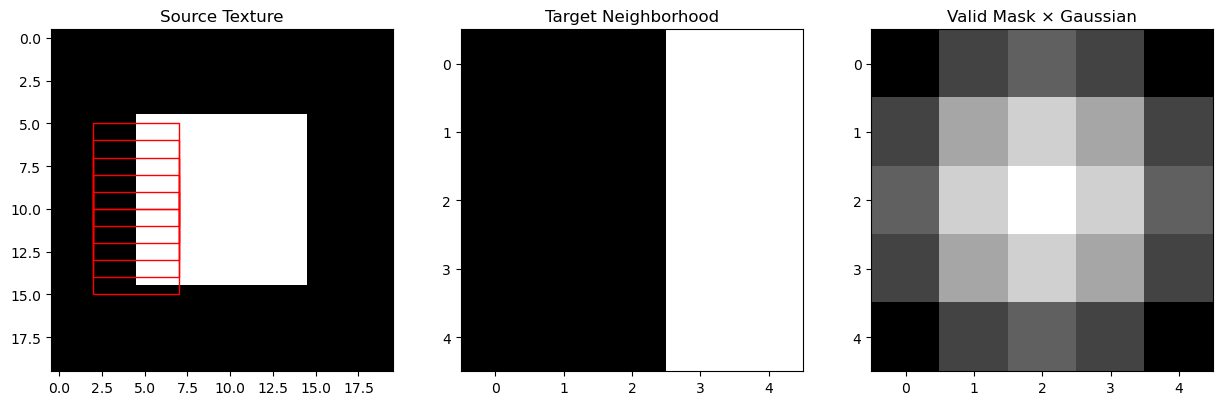

Found 6 matches


In [9]:
def test_neighborhood_matching():
    # Create a simple test texture
    source = np.zeros((20, 20))
    source[5:15, 5:15] = 1  # White square in center
    # Create a target neighborhood that should match the edge of the square
    window_size = 5
    target = np.zeros((window_size, window_size))
    target[:, :3] = 0
    target[:, 3:] = 1
    # Create valid mask (all pixels valid in this test)
    valid_mask = np.ones_like(target)
    # Create Gaussian window
    gaussian = create_gaussian_window(window_size)
    # Find matches
    matches = find_matching_neighborhoods(target, source, gaussian, valid_mask)
    # Visualize
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(source, cmap='gray')
    plt.title('Source Texture')
    # Highlight matches
    for i, j in matches:
        rect = plt.Rectangle((j-window_size//2, i-window_size//2), 
                           window_size, window_size, 
                           fill=False, color='red')
        plt.gca().add_patch(rect)
    plt.subplot(132)
    plt.imshow(target, cmap='gray')
    plt.title('Target Neighborhood')
    plt.subplot(133)
    plt.imshow(valid_mask * gaussian, cmap='gray')
    plt.title('Valid Mask × Gaussian')
    plt.show()
    
    print(f"Found {len(matches)} matches")

test_neighborhood_matching()

## Part 4: Implement the Main Synthesis Loop 

This section brings together all the components to implement the complete Efros-Leung texture synthesis algorithm. The main synthesis loop grows the texture outward from an initial seed, carefully choosing the order of pixel synthesis and sampling from matching neighborhoods.

Key Concepts:

1. Seed Initialization: Start with a small patch from source texture
2. Growth Order: Always fill pixels with most known neighbors first
3. Partial Neighborhoods: Handle neighborhoods that are partially filled
4. Random Sampling: Choose randomly from valid matches to avoid repetition

In [ ]:
def synthesize_texture(source_texture: np.ndarray,
                      output_size: Tuple[int, int],
                      window_size: int = 15,
                      threshold: float = 0.01,
                      visualize: bool = True) -> np.ndarray:
    """Synthesize a new texture using Efros & Leung's algorithm.
    
    Args:
        source_texture: Source texture to sample from
        output_size: Size of texture to synthesize (height, width)
        window_size: Size of neighborhood window (should be odd)
        threshold: Threshold for neighborhood matching
        
    Returns:
        Synthesized texture as numpy array
    """
    # Initialize output texture with zeros and the seed_size
    output = np.zeros(output_size)
    mask = np.zeros(output_size, dtype=bool)
    seed_size = 3
    pad = window_size // 2
    gaussian_window = create_gaussian_window (window_size)
    
    #pad the output and mask
    padded_output = np.pad(output, pad, 'constant', constant_values=0)
    padded_mask = np.pad(mask, pad, 'constant', constant_values=0)
    
    # for now I will choose the center 3x3 of the source to be the seed
    out_height, out_width = padded_output.shape
    source_height, source_width = source_texture.shape
    out_h_start = (out_height - seed_size) // 2
    out_w_start = (out_width - seed_size)// 2
    source_h_start = (source_height - seed_size) // 2
    source_w_start = (source_width - seed_size) // 2
    
    padded_output[out_h_start: out_h_start + seed_size, 
                  out_w_start: out_w_start + seed_size] = \
                      source_texture[source_h_start: source_h_start + seed_size, 
                                     source_w_start: source_w_start + seed_size]
    padded_mask[out_h_start: out_h_start + seed_size, 
                out_w_start: out_w_start + seed_size] = True

    for i in range(output_size[0] * output_size[1] - seed_size**2):
        # Create a list of which pixels have the most neighbors and start filling
        neighbor_cnts = get_unfilled_neighbors_count(padded_mask[pad:-pad, pad:-pad], window_size)
        most_filled_neighbors = np.max(neighbor_cnts)
        to_fill = np.argwhere(neighbor_cnts == most_filled_neighbors) + pad
        random_pixel = to_fill[np.random.choice(to_fill.shape[0])]
        
        x, y = random_pixel
        target_neighborhood = padded_output[x - pad: x + pad + 1, y - pad: y + pad + 1]
        valid_mask = padded_mask[x - pad: x + pad + 1, y - pad: y + pad + 1]
        matching_neighborhoods = find_matching_neighborhoods(target_neighborhood, 
                                                            source_texture, 
                                                            gaussian_window, 
                                                            valid_mask, 
                                                            threshold)
        
        random_match = matching_neighborhoods[np.random.choice(len(matching_neighborhoods))]
        padded_output[x, y] = source_texture[random_match[0], random_match[1]]
        padded_mask[x,y] = True
        if i % 1000 == 0 and visualize:
            visualize_progress(padded_output, padded_mask, step=i)
        i += 1
    return padded_output[pad:-pad, pad:-pad]

## Part 5: Testing the Algorithm 

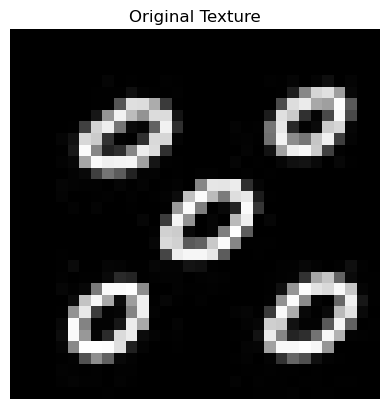

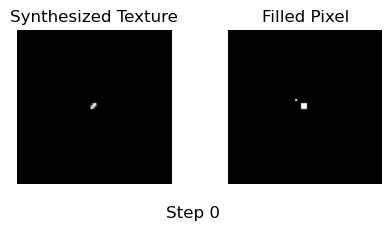

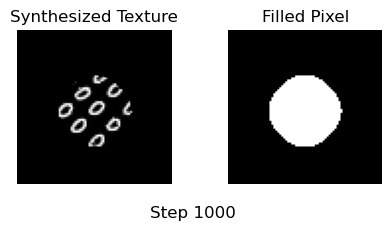

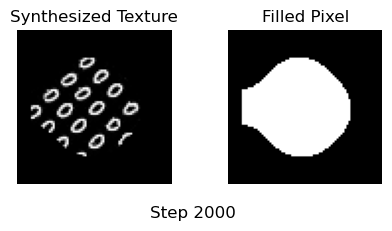

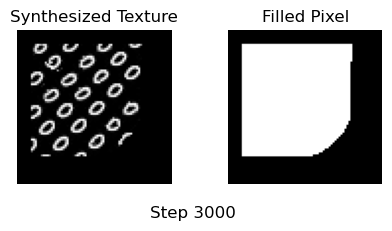

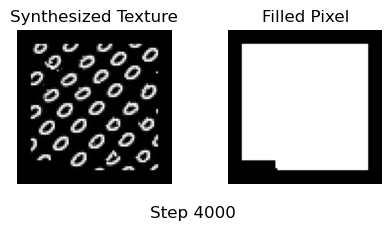

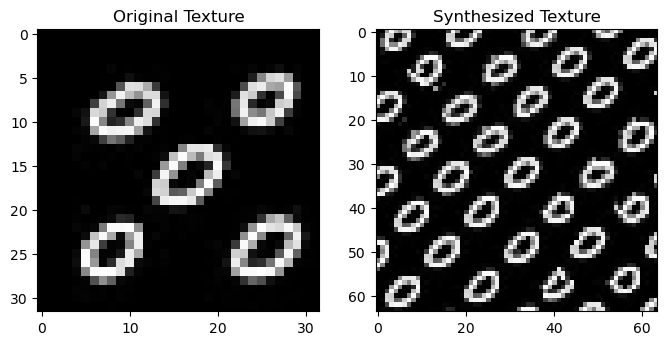

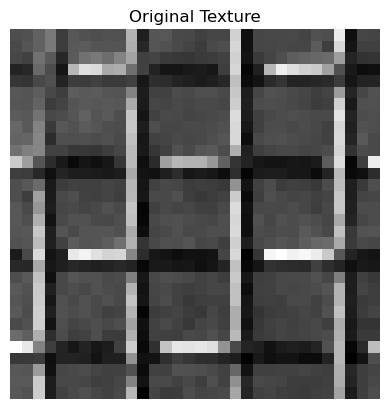

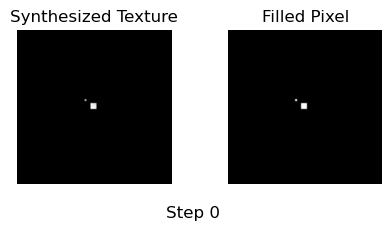

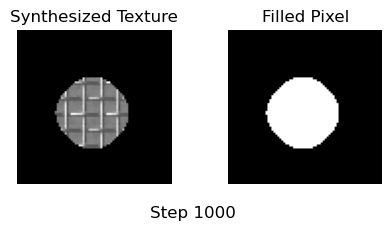

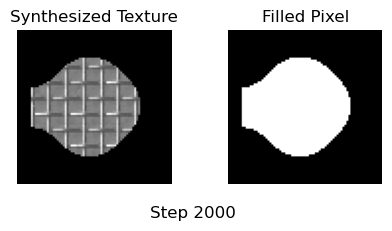

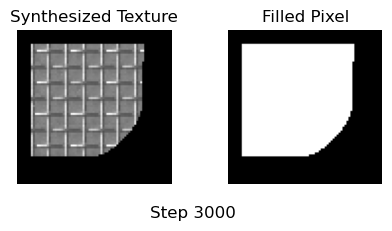

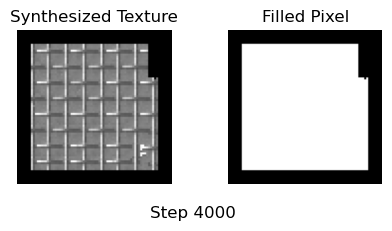

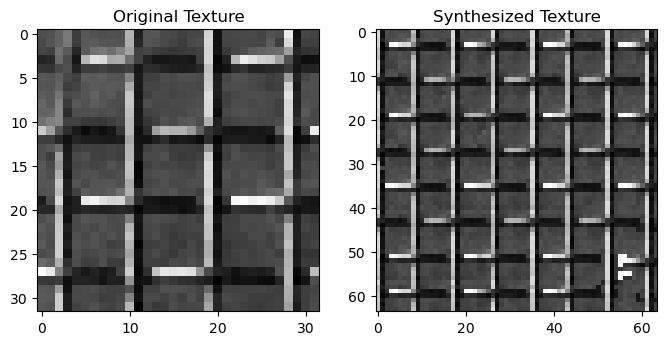

In [11]:
texture0 = 'texture/texture0.jpg'
texture1 = 'texture/texture1.jpg'
for texture_name in [texture0, texture1]:
    texture = load_texture(texture_name, (32, 32))
    
    synthesized = synthesize_texture(
        source_texture=texture,
        output_size=(64, 64),
        window_size=15,
        threshold=0.01
    )
    # Display results
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(texture, cmap='gray')
    plt.title('Original Texture')
    plt.subplot(122)
    plt.imshow(synthesized, cmap='gray')
    plt.title('Synthesized Texture')
    plt.show()

Now play with different parameters to see how they works in the algorithm.

The following code changes window_size. Please run it first to observe how does this parameter change influence the result. Next, write code to change at least one another parameter to see how the parameter change influence the result.

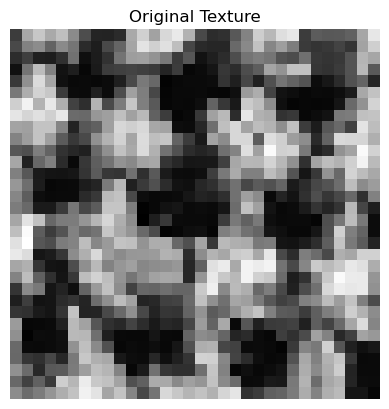

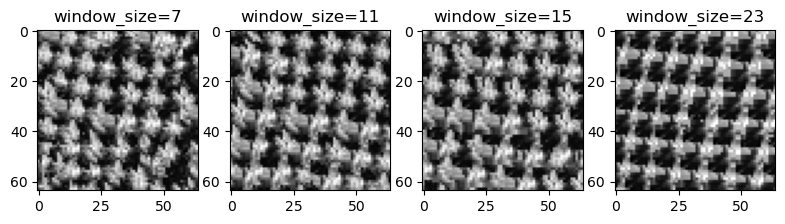

In [12]:
texture0 = 'texture/texture4.jpg'
texture = load_texture(texture0, (32, 32))
window_sizes = [7, 11, 15, 23]
plt.figure(figsize=(12, 4))
plt.subplot(1, len(window_sizes) + 1, 1)
plt.imshow(texture, cmap='grey')
plt.title('Original')
for i, window_size in enumerate(window_sizes):
    synthesized = synthesize_texture(
        source_texture=texture,
        output_size=(64, 64),
        window_size=window_size,
        threshold=0.01,
        visualize=False
    )
    plt.subplot(1, len(window_sizes) + 1, i+1)
    plt.imshow(synthesized, cmap='gray')
    plt.title(f"window_size={window_size}")
plt.show()

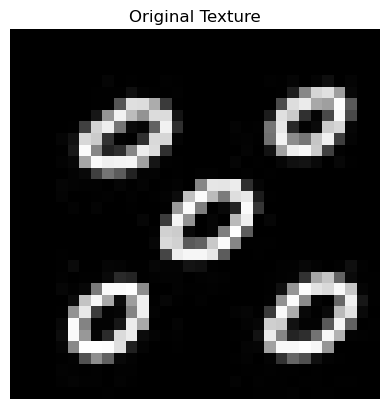

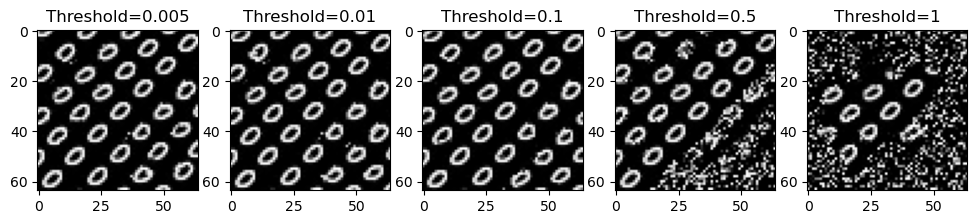

In [ ]:

texture0 = 'texture/texture0.jpg'
texture = load_texture(texture0, (32, 32))
thresholds = [0.005, 0.01, 0.10, 0.5, 1]
plt.figure(figsize=(12, 4))
plt.subplot(1, len(window_sizes) + 1, 1)
plt.imshow(texture, cmap='grey')
plt.title('Original')
for i, threshold in enumerate(thresholds):
    synthesized = synthesize_texture(
        source_texture=texture,
        output_size=(64, 64),
        window_size=15,
        threshold=threshold,
        visualize=False
    )
    plt.subplot(1, len(window_sizes) + 1, i+1)
    plt.imshow(synthesized, cmap='gray')
    plt.title(f"Threshold={threshold}")
plt.show()

# Image Quilting Implementation

Now that I've implemented the Efros-Leung texture synthesis algorithm, I have a good foundation for implementing another seminal paper in texture synthesis - "Image Quilting for Texture Synthesis and Transfer" by Efros and Freeman (SIGGRAPH 2001): https://dl.acm.org/doi/pdf/10.1145/383259.383296


My goal is to modify my existing texture synthesis code to implement the Image Quilting algorithm. Rather than synthesizing one pixel at a time, this algorithm:

1. Takes square blocks from the input texture and patches them together
2. Uses overlap between adjacent blocks to find good matches
3. Computes minimum error boundary cuts between overlapping blocks to reduce visual artifacts

My implementation includes:

1. Random block placement for the first block
2. Finding matching blocks considering overlap regions
3. Computing minimum error boundary cuts using dynamic programming
4. Proper handling of both vertical and horizontal overlaps

## Part 1: Compute minimum error boundary cuts using DP

In [129]:
import heapq

# Edited to work better with corners. In this implementation block1 is the current output where block2 should go
def min_error_boundary(
    block1: np.ndarray,
    block2: np.ndarray,
    overlap_size: int,
    direction: str = 'vertical'  # or 'horizontal' or 'corner'
) -> np.ndarray:
    
    distances = np.full(block1.shape, np.inf)
    prio_queue = []
    prev_dist = {}
    
    overlap = (block1 - block2) ** 2
    
    # Essentially a valid mask based on the type of overlap occuring
    # Adding the starting positions for dkjistra's
    if direction == 'horizontal':
        overlap[overlap_size:,:] = -1
        distances[0:overlap_size,0] = 0
        for i in range(overlap_size):
            heapq.heappush(prio_queue,(distances[i, 0], (i, 0)))
            
    elif direction == 'vertical':
        overlap[:, overlap_size:] = -1
        distances[0, 0:overlap_size] = 0
        for i in range(overlap_size):
            heapq.heappush(prio_queue,(distances[0, i], (0, i)))
            
    elif direction == 'corner':
        overlap[overlap_size:,overlap_size:] = -1
        distances[0:overlap_size,-1] = 0
        for i in range(overlap_size):
            heapq.heappush(prio_queue,(distances[i, -1], (i, block1.shape[1]-1)))
   
   
    while prio_queue:
        cur_dist, cur_coord = heapq.heappop(prio_queue)
        x, y = cur_coord
        neighbors = []
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                if i == 0 and j == 0:
                    continue
                r, c = x + i, y + j
                if 0 <= r < len(distances) and 0 <= c < len(distances[0]) and overlap[r,c] != -1:
                    neighbors.append((r, c))
        
        # Implementation allowed for diagonal boundary lines
        for neighbor in neighbors:
            total_cost = overlap[neighbor[0], neighbor[1]] + cur_dist
            
            if total_cost < distances[neighbor[0], neighbor[1]]:
                distances[neighbor[0], neighbor[1]] = total_cost
                heapq.heappush(prio_queue, (total_cost, (neighbor[0], neighbor[1])))
                prev_dist[(neighbor[0], neighbor[1])] = (x, y)

    # Made the targets the bottom left for  vertical and corner overlap
    if direction == 'vertical' or direction == 'corner':         
        min_col_index = np.argmin(distances[-1, 0:overlap_size])
        node = (block1.shape[0] - 1, min_col_index)
    # Target is top right for horizontal
    elif direction == 'horizontal':         
        min_row_index = np.argmin(distances[0:overlap_size,-1])
        node = (min_row_index, block1.shape[1] - 1)
    
    path = []
    
    # Backtraces the shortest path
    while node in prev_dist:
        path.append(node)
        node = prev_dist[node]
    path.append(node)
    path = np.array(path)
    
    # Drew out path with 0 in binary mask
    mask = np.ones_like(block1)
    for x, y in path:
        mask[x,y] = 0  
    
    # Recursively fills in mask with 0's bounded by the minimum error boundary
    def bucket_fill(x, y):
        if x < 0 or x >= mask.shape[0] or y < 0 or y >= mask.shape[1]:
            return
        
        if mask[x, y] == 1:
            mask[x, y] = 0
            for i, j in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                new_x, new_y = x + i, y + j
                if 0 <= new_x < mask.shape[0] and 0 <= new_y < mask.shape[1]:
                    bucket_fill(new_x, new_y)
    
    # Filling based on overlap
    if direction == 'vertical':
        for i in range(mask.shape[0]):
            bucket_fill(i, 0)
    elif direction == 'horizontal':
        for i in range(mask.shape[1]):
            bucket_fill(0, i)
    elif direction == 'corner':
        for i in range(mask.shape[0]):
            bucket_fill(i, 0)
        for i in range(1, mask.shape[1]):
            bucket_fill(0, i)
    
    
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.show()
    plt.figure(figsize=(4, 4))
    plt.subplot(121)
    plt.imshow(block1, cmap='gray')
    plt.title('Overlap')
    plt.subplot(122)
    plt.imshow(block2, cmap='gray')
    plt.title('Block2')
    plt.show()

    return mask
    


# texture = load_texture("texture/texture4.jpg", (96, 96))
# block_size = 64
# block1 = texture[0:block_size, 0:block_size]
# block2 = texture[-block_size:, -block_size:]
# gradient = np.linspace(1, 20, 20)[np.newaxis, :]

# block1 = np.tile(gradient, (20, 1))
# block2 = np.tile(gradient.T, (1, 20))

# boundary1 = min_error_boundary(block1, block2, 8, 'horizontal')
# boundary2 = min_error_boundary(block1, block2, 8, 'vertical')

# plt.figure(figsize=(8, 4))
# plt.subplot(121)
# plt.imshow(boundary1, cmap='gray')
# plt.title('Horizontal Boundary')
# plt.subplot(122)
# plt.imshow(boundary2, cmap='gray')
# plt.title('Vertical Boundary')


# # Display results
# plt.figure(figsize=(8, 4))
# plt.subplot(121)
# plt.imshow(block1, cmap='gray')
# plt.title('Block1')
# plt.subplot(122)
# plt.imshow(block2, cmap='gray')
# plt.title('Block2')
# plt.show()



## Part 2: Synthesize texture quiltering

In [ ]:
def select_matching_block(output: np.ndarray,
                              source_texture: np.ndarray,
                              overlap_size = int,
                              threshold: float = 0.01,
                              direction = 'vertical') -> list:
    
    block_size = output.shape[0]
    ssd_matrix = np.full_like(source_texture, np.inf)
    good_matches = []
    valid_mask = np.zeros((block_size, block_size))
    
    if direction == 'vertical':
        valid_mask[:, 0:overlap_size] = 1
    elif direction == 'horizontal':
        valid_mask[0:overlap_size, :] = 1
    elif direction == 'corner':
        valid_mask[:, 0:overlap_size] = 1
        valid_mask[0:overlap_size, overlap_size:] = 1
        
    # We now find the difference between the target neighborhood and every valid neighborhood in the source
    for x in range(source_texture.shape[0] - block_size + 1):
        for y in range(source_texture.shape[1] - block_size + 1):
            source_block = source_texture[x:x + block_size, y:y + block_size]
            ssd_matrix[x, y] = np.sum((source_block * valid_mask - output)**2)
        
    
    # Getting the indices for coordinates under threshold
    min_ssd = np.min(ssd_matrix)
    # ssd_list = np.argwhere(ssd_matrix <= min_ssd * (1 + threshold))
    ssd_list = np.argwhere(ssd_matrix <= min_ssd * (1 + threshold))
    
    # adjusting coordinates back to source texture
    good_matches = ssd_list.tolist()
    random_match = good_matches[np.random.choice(len(good_matches))]
    
    return random_match

def synthesize_texture_quilting(
    source_texture: np.ndarray,
    output_size: Tuple[int, int],
    block_size: int = 32,
    overlap_size: int = 8,
    threshold: float = 0.1,
    visualize: bool = True
) -> np.ndarray:

    output = np.zeros(output_size)
    
    step = block_size - overlap_size
    for i in range(0, output_size[0]-overlap_size, step):
        for j in range(0, output_size[1] - overlap_size, step):
            
            mask = np.ones((block_size, block_size))
            has_vertical_edge = j - step >= 0
            has_horizontal_edge = i - step >= 0
            new_block_area = output[i:i + block_size, j:j + block_size]
            
            # Case for top left block
            if not has_vertical_edge and not has_horizontal_edge:
                random_x = np.random.choice(source_texture.shape[0] - block_size + 1)
                random_y = np.random.choice(source_texture.shape[1] - block_size + 1)
                block2 = source_texture[random_x: random_x + block_size, random_y: random_y + block_size]
            else:
                # Case for first row of blocks
                if has_vertical_edge and not has_horizontal_edge:
                    direction='vertical'
                # Case for first column of blocks
                elif has_horizontal_edge and not has_vertical_edge:
                    direction='horizontal'
                else:
                    direction = 'corner'
                    
                x, y = select_matching_block(new_block_area, 
                                                source_texture, 
                                                overlap_size, 
                                                threshold, 
                                                direction)
                        
                block2 = source_texture[x: x + block_size, y: y + block_size]
                
                # Makes appropriate mask depending on overlap
                mask = min_error_boundary(output[i:i + block_size, j:j + block_size], 
                                                  block2, overlap_size, direction)
            
            
            output[i:i + block_size, j:j + block_size] = np.where(mask == 0, new_block_area, block2)
            
    return output

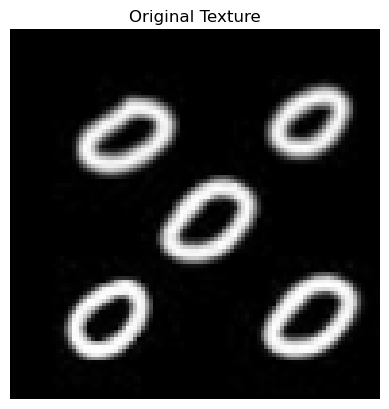

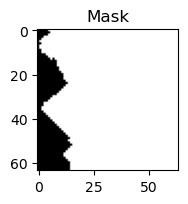

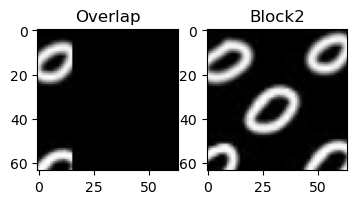

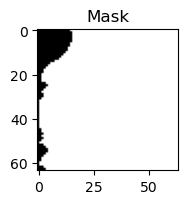

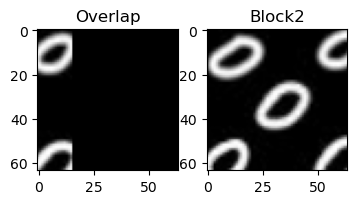

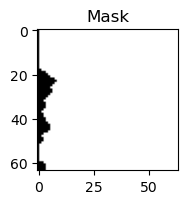

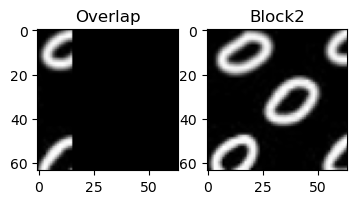

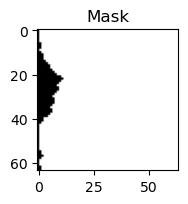

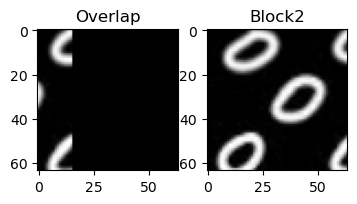

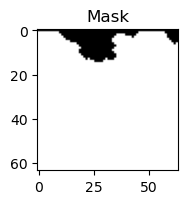

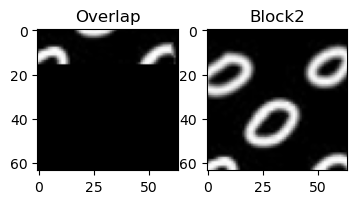

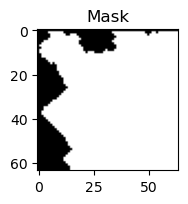

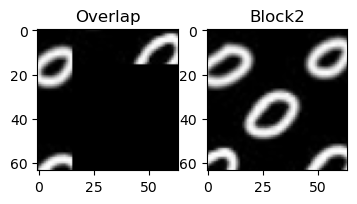

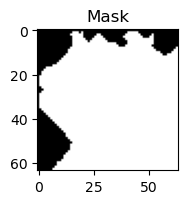

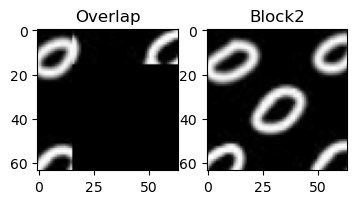

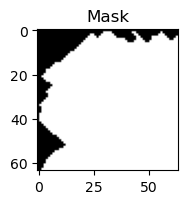

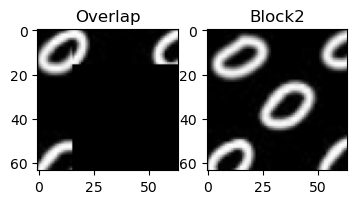

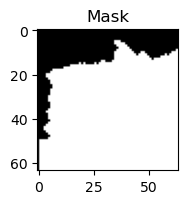

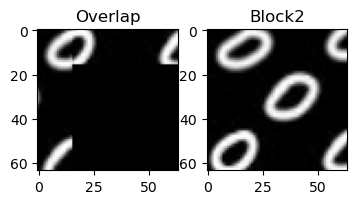

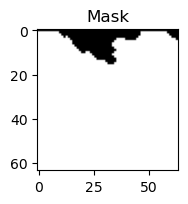

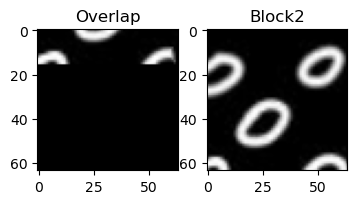

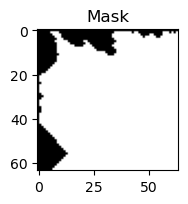

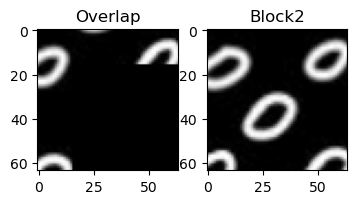

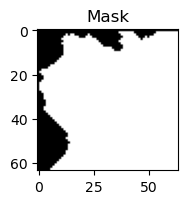

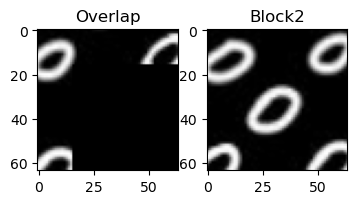

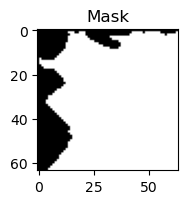

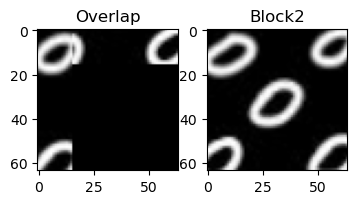

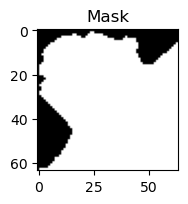

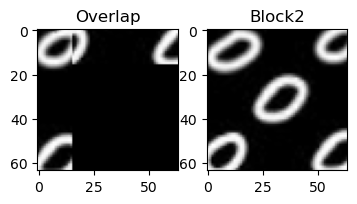

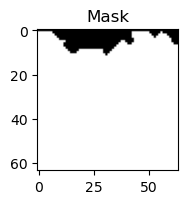

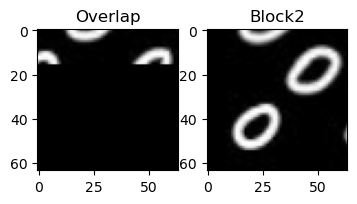

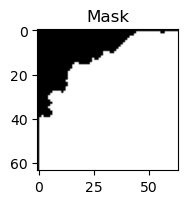

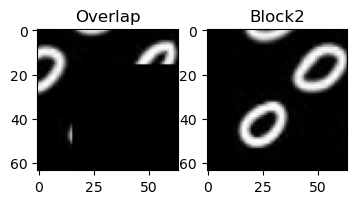

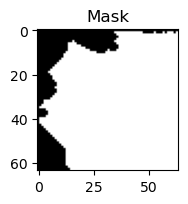

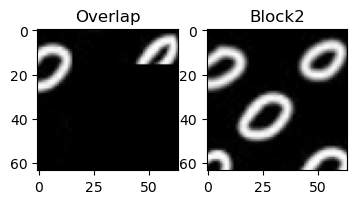

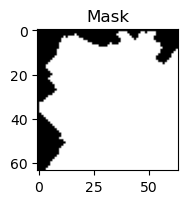

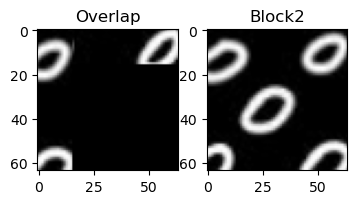

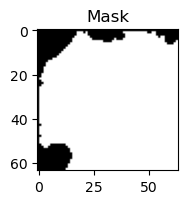

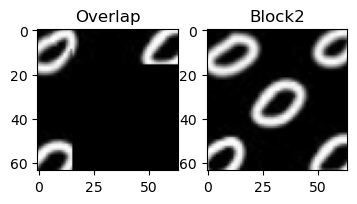

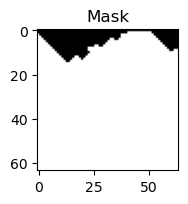

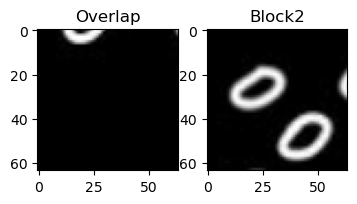

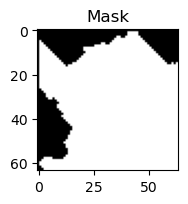

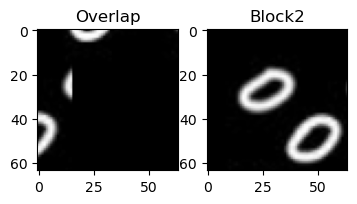

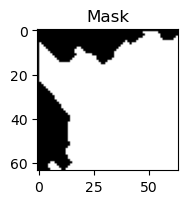

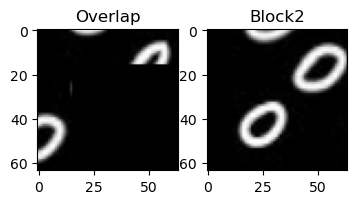

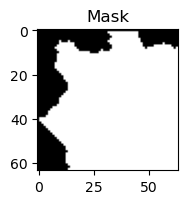

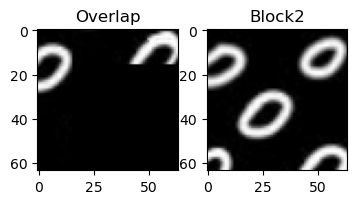

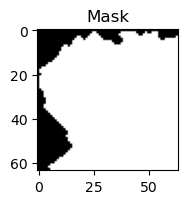

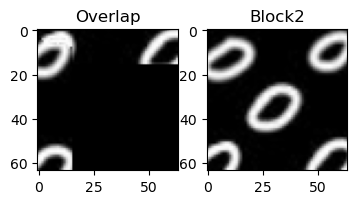

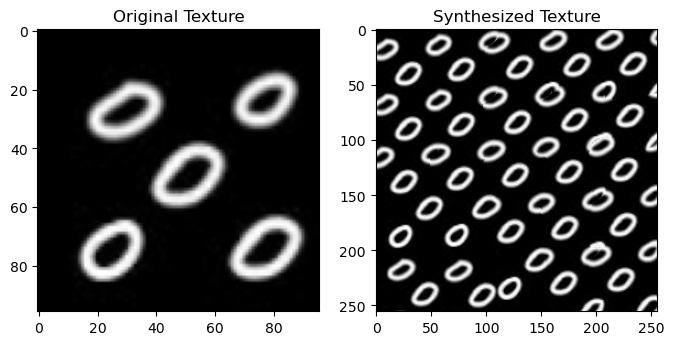

In [130]:
texture = load_texture("texture/texture0.jpg", (96, 96))

# Synthesize new texture
synthesized = synthesize_texture_quilting(
    source_texture=texture,
    output_size=(256, 256),
    block_size=64,
    overlap_size=16,
    threshold=0.1
)

# Display results
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(texture, cmap='gray')
plt.title('Original Texture')
plt.subplot(122)
plt.imshow(synthesized, cmap='gray')
plt.title('Synthesized Texture')
plt.show()